# API Call Stuff

In [1]:
import os

import pandas as pd
import numpy as np
import duckdb
from duckdb.typing import DOUBLE, INTEGER, VARCHAR

import h3
import plotly.express as px
import matplotlib.pyplot as plt

from folium import Map, Marker, GeoJson
import folium
import branca.colormap as bcm
from geojson.feature import Feature, FeatureCollection
import geojson

import json
from tqdm import tqdm

/var/folders/bb/g7vlcgfn14ld8_w41331g0dw0000gn/T/ipykernel_29888/1823311781.py:6: DeprecationWarning: `duckdb.typing` is deprecated and will be removed in a future version. Please use `duckdb.sqltypes` instead.
  from duckdb.typing import DOUBLE, INTEGER, VARCHAR


# DuckDB Connection

In [2]:
TAXI_DUCKDB_PATH = "../nyc_traffic_2016.duckdb"

con = duckdb.connect(TAXI_DUCKDB_PATH, read_only=False)

In [7]:
con.query("SELECT column_name, data_type FROM information_schema.columns WHERE table_name = 'taxi_data'")

┌───────────────────────┬───────────┐
│      column_name      │ data_type │
│        varchar        │  varchar  │
├───────────────────────┼───────────┤
│ VendorID              │ BIGINT    │
│ tpep_pickup_datetime  │ VARCHAR   │
│ tpep_dropoff_datetime │ VARCHAR   │
│ passenger_count       │ BIGINT    │
│ trip_distance         │ DOUBLE    │
│ pickup_longitude      │ DOUBLE    │
│ pickup_latitude       │ DOUBLE    │
│ RatecodeID            │ BIGINT    │
│ store_and_fwd_flag    │ VARCHAR   │
│ dropoff_longitude     │ DOUBLE    │
│ dropoff_latitude      │ DOUBLE    │
│ payment_type          │ BIGINT    │
│ fare_amount           │ DOUBLE    │
│ extra                 │ DOUBLE    │
│ mta_tax               │ DOUBLE    │
│ tip_amount            │ DOUBLE    │
│ tolls_amount          │ DOUBLE    │
│ improvement_surcharge │ DOUBLE    │
│ total_amount          │ DOUBLE    │
│ PULocationID          │ DOUBLE    │
│ DOLocationID          │ DOUBLE    │
├───────────────────────┴───────────┤
│ 21 rows   

## Convert Datetime Columns

In [14]:
con.query("ALTER TABLE taxi_data ADD COLUMN pickup_datetime TIMESTAMP;")
con.query("UPDATE taxi_data SET pickup_datetime = STRPTIME(tpep_pickup_datetime, '%m/%d/%Y %I:%M:%S %p');")

con.query("ALTER TABLE taxi_data ADD COLUMN dropoff_datetime TIMESTAMP;")
con.query("UPDATE taxi_data SET dropoff_datetime = STRPTIME(tpep_dropoff_datetime, '%m/%d/%Y %I:%M:%S %p');")

## Add in Hex Cell Columns

In [ ]:
def safe_latlng_cell(lat, lon, res): # allow returning of null value upon error, like no coords present
    try:
        return h3.latlng_to_cell(lat, lon, res)
    except Exception:
        return None

con.create_function(
    'latlng_cell',
    safe_latlng_cell,
    parameters=[DOUBLE, DOUBLE, INTEGER],
    return_type=VARCHAR
)

# Test whether the function was correctly registered
con.query("SELECT latlng_cell(10, 10, 10)")

┌─────────────────────────┐
│ latlng_cell(10, 10, 10) │
│         varchar         │
├─────────────────────────┤
│ 8a58e0682d6ffff         │
└─────────────────────────┘

In [29]:
con.query("ALTER TABLE taxi_data ADD COLUMN pickup_hex10 VARCHAR;")
con.query("UPDATE taxi_data SET pickup_hex10 = latlng_cell(pickup_latitude, pickup_longitude, 10)")

con.query("ALTER TABLE taxi_data ADD COLUMN dropoff_hex10 VARCHAR;")
con.query("UPDATE taxi_data SET dropoff_hex10 = latlng_cell(dropoff_latitude, dropoff_longitude, 10)")

con.query("ALTER TABLE taxi_data ADD COLUMN pickup_hex9 VARCHAR;")
con.query("UPDATE taxi_data SET pickup_hex9 = latlng_cell(pickup_latitude, pickup_longitude, 9)")

con.query("ALTER TABLE taxi_data ADD COLUMN dropoff_hex9 VARCHAR;")
con.query("UPDATE taxi_data SET dropoff_hex9 = latlng_cell(dropoff_latitude, dropoff_longitude, 9)")

In [30]:
test_df = con.query("SELECT * FROM taxi_data LIMIT 10").df()
test_df

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,pickup_longitude,pickup_latitude,RatecodeID,store_and_fwd_flag,dropoff_longitude,...,improvement_surcharge,total_amount,PULocationID,DOLocationID,pickup_datetime,dropoff_datetime,pickup_hex10,dropoff_hex10,pickup_hex9,dropoff_hex9
0,1,01/08/2016 10:33:13 AM,01/08/2016 11:06:34 AM,2,11.20,-73.863617,40.769569,1,N,-73.981033,...,0.3,49.59,NaN,NaN,2016-01-08 10:33:13,2016-01-08 11:06:34,8a2a100e2517fff,8a2a100d655ffff,892a100e253ffff,892a100d657ffff
1,1,01/26/2016 10:05:54 AM,01/26/2016 10:29:29 AM,1,4.50,-73.945717,40.773994,1,N,-73.993813,...,0.3,18.30,NaN,NaN,2016-01-26 10:05:54,2016-01-26 10:29:29,8a2a10089a4ffff,8a2a100d2677fff,892a10089a7ffff,892a100d267ffff
2,2,01/05/2016 04:20:50 PM,01/05/2016 04:28:07 PM,5,1.10,-73.957718,40.773685,1,N,-73.954727,...,0.3,8.80,NaN,NaN,2016-01-05 16:20:50,2016-01-05 16:28:07,8a2a100893affff,8a2a100898b7fff,892a100893bffff,892a100898bffff
3,1,01/30/2016 11:30:14 PM,01/31/2016 12:06:36 AM,3,4.90,-73.993652,40.720943,1,N,-73.986923,...,0.3,26.30,NaN,NaN,2016-01-30 23:30:14,2016-01-31 00:06:36,8a2a1072caa7fff,8a2a1008b047fff,892a1072cabffff,892a1008b07ffff
4,2,01/30/2016 01:35:36 PM,01/30/2016 01:47:59 PM,1,1.92,-73.986382,40.762329,1,N,-73.999771,...,0.3,14.04,NaN,NaN,2016-01-30 13:35:36,2016-01-30 13:47:59,8a2a100d64affff,8a2a100d241ffff,892a100d64bffff,892a100d243ffff
5,2,01/13/2016 03:23:09 PM,01/13/2016 04:17:53 PM,1,17.54,-73.781845,40.644821,2,N,-73.963776,...,0.3,52.80,NaN,NaN,2016-01-13 15:23:09,2016-01-13 16:17:53,8a2a103b1c97fff,8a2a100d6acffff,892a103b1cbffff,892a100d6afffff
6,1,01/16/2016 07:43:19 AM,01/16/2016 07:54:46 AM,1,3.30,-73.991623,40.750050,1,N,-73.992188,...,0.3,12.80,NaN,NaN,2016-01-16 07:43:19,2016-01-16 07:54:46,8a2a100d2c17fff,8a2a1072dca7fff,892a100d2c3ffff,892a1072dcbffff
7,1,01/20/2016 06:02:11 PM,01/20/2016 06:04:59 PM,1,0.50,-73.980049,40.760002,1,N,-73.980972,...,0.3,6.80,NaN,NaN,2016-01-20 18:02:11,2016-01-20 18:04:59,8a2a100d646ffff,8a2a100d652ffff,892a100d647ffff,892a100d653ffff
8,2,01/30/2016 09:02:21 PM,01/30/2016 09:21:27 PM,1,1.78,-74.006935,40.739979,1,N,-73.982254,...,0.3,13.80,NaN,NaN,2016-01-30 21:02:21,2016-01-30 21:21:27,8a2a10721a37fff,8a2a100d230ffff,892a10721a3ffff,892a100d233ffff
9,2,01/22/2016 03:18:35 PM,01/22/2016 03:30:08 PM,2,1.44,-74.000046,40.719090,1,N,-74.015617,...,0.3,12.25,NaN,NaN,2016-01-22 15:18:35,2016-01-22 15:30:08,8a2a1072c3a7fff,8a2a10728d5ffff,892a1072c07ffff,892a10728d7ffff


# Aggregating By Time
One of the first things we will do is to determine the number of unique dates which have valid trips on them.

In [120]:
total_rows = con.query("""SELECT
                       COUNT(*) as total_rows
                       FROM
                        taxi_data""").fetchone()[0]

unique_rows = con.query("""SELECT
                        COUNT(*) AS unique_rows
                        FROM
                            taxi_data
                        WHERE
                            pickup_hex10 IS NOT NULL AND dropoff_hex10 IS NOT NULL;""").fetchone()[0]

unique_days = con.query("""SELECT
                        COUNT(DISTINCT DATE_TRUNC('DAY', pickup_datetime)) AS unique_days
                        FROM
                            taxi_data
                        WHERE
                            pickup_hex10 IS NOT NULL AND dropoff_hex10 IS NOT NULL;""").fetchone()[0]

unique_months = con.query("""SELECT
                        COUNT(DISTINCT DATE_TRUNC('MONTH', pickup_datetime)) AS unique_months
                        FROM
                            taxi_data
                        WHERE
                            pickup_hex10 IS NOT NULL AND dropoff_hex10 IS NOT NULL;""").fetchone()[0]

In [123]:
print(f"Percent of Rows with Lat/Lon {unique_rows * 100 / total_rows} \n \t {unique_rows} out of {total_rows}")
print(f"Unique Dates {unique_days}")
print(f"Unique Months: {unique_months}")

Percent of Rows with Lat/Lon 52.9154097864322 
 	 69406520 out of 131165043
Unique Dates 182
Unique Months: 6


In [ ]:
def total_trips_by_hour(con, target_id, resolution):
    if target_id == "pu_do":
        key_str = f"pu_do_pair{resolution}"
        select_str = f"CONCAT(pickup_hex{resolution}, '_', dropoff_hex{resolution}) AS {key_str}"
    if target_id == 'pu':
        key_str = f"pickup_hex{resolution}"
        select_str = key_str
    elif target_id == 'do':
        key_str = f"dropoff_hex{resolution}"
        select_str = key_str
    
    hr_query = f"""
    SELECT
        {select_str},
        EXTRACT(HOUR FROM pickup_datetime) AS trip_hour,
        COUNT(*) AS total_trips
    FROM
        taxi_data
    WHERE
        pickup_hex{resolution} IS NOT NULL AND dropoff_hex{resolution} IS NOT NULL
    GROUP BY
        {key_str},
        trip_hour
    ORDER BY
        {key_str}, trip_hour;
    """

    hr_df = con.query(hr_query).df()

    hr_df = hr_df.set_index([f'{key_str}', 'trip_hour'])

    return hr_df

In [131]:
def total_trips_by_day(con, target_id, resolution):
    if target_id == "pu_do":
        key_str = f"pu_do_pair{resolution}"
        select_str = f"CONCAT(pickup_hex{resolution}, '_', dropoff_hex{resolution}) AS {key_str}"
    elif target_id == 'pu':
        key_str = f"pickup_hex{resolution}"
        select_str = key_str
    elif target_id == 'do':
        key_str = f"dropoff_hex{resolution}"
        select_str = key_str

    day_query = f"""
    SELECT
        {select_str},
        EXTRACT(DOW FROM pickup_datetime) AS trip_day,
        COUNT(*) AS total_trips
    FROM
        taxi_data
    WHERE
        pickup_hex{resolution} IS NOT NULL AND dropoff_hex{resolution} IS NOT NULL
    GROUP BY
        {key_str},
        trip_day
    ORDER BY
        {key_str}, trip_day;
    """

    day_df = con.query(day_query).df()
    day_df = day_df.set_index([f'{key_str}', 'trip_day'])

    return day_df

In [132]:
def total_trips_by_month(con, target_id, resolution):
    if target_id == "pu_do":
        key_str = f"pu_do_pair{resolution}"
        select_str = f"CONCAT(pickup_hex{resolution}, '_', dropoff_hex{resolution}) AS {key_str}"
    elif target_id == 'pu':
        key_str = f"pickup_hex{resolution}"
        select_str = key_str
    elif target_id == 'do':
        key_str = f"dropoff_hex{resolution}"
        select_str = key_str

    month_query = f"""
    SELECT
        {select_str},
        EXTRACT(MONTH FROM pickup_datetime) AS trip_month,
        COUNT(*) AS total_trips
    FROM
        taxi_data
    WHERE
        pickup_hex{resolution} IS NOT NULL AND dropoff_hex{resolution} IS NOT NULL
    GROUP BY
        {key_str},
        trip_month
    ORDER BY
        {key_str}, trip_month;
    """

    month_df = con.query(month_query).df()
    month_df = month_df.set_index([f'{key_str}', 'trip_month'])

    return month_df

In [124]:
hr_pu9 = total_trips_by_hour(con, 'pu', 9)
hr_do9 = total_trips_by_hour(con, 'do', 9)
hr_pu_do9 = total_trips_by_hour(con, 'pu_do', 9)

hr_pu10 = total_trips_by_hour(con, 'pu', 10)
hr_do10 = total_trips_by_hour(con, 'do', 10)
hr_pu_do10 = total_trips_by_hour(con, 'pu_do', 10)

In [133]:
day_pu9 = total_trips_by_day(con, 'pu', 9)
day_do9 = total_trips_by_day(con, 'do', 9)
day_pu_do9 = total_trips_by_day(con, 'pu_do', 9)

day_pu10 = total_trips_by_day(con, 'pu', 10)
day_do10 = total_trips_by_day(con, 'do', 10)
day_pu_do10 = total_trips_by_day(con, 'pu_do', 10)

In [134]:
month_pu9 = total_trips_by_month(con, 'pu', 9)
month_do9 = total_trips_by_month(con, 'do', 9)
month_pu_do9 = total_trips_by_month(con, 'pu_do', 9)

month_pu10 = total_trips_by_month(con, 'pu', 10)
month_do10 = total_trips_by_month(con, 'do', 10)
month_pu_do10 = total_trips_by_month(con, 'pu_do', 10)

In [ ]:
most_pop_query10 = """
    SELECT
        CONCAT(pickup_hex10, '_', dropoff_hex10) AS pu_do10,
        COUNT(*) AS total_trips
    FROM
        taxi_data
    WHERE
        pickup_hex10 IS NOT NULL AND dropoff_hex10 IS NOT NULL
    GROUP BY
        pu_do10
    ORDER BY
        pu_do10
    """

pop_pairs10 = con.query(most_pop_query10).df()

In [208]:
top10_pairs10 = pop_pairs10.sort_values(by='total_trips', ascending=False).head(10)
top10_pairs10

,pu_do10,total_trips
8140438,8a754e64992ffff_8a754e64992ffff,827100
4338833,8a2a100d666ffff_8a2a100d2c17fff,10733
1885301,8a2a100d0927fff_8a2a100d0927fff,10384
3555063,8a2a100d48c7fff_8a2a100d48c7fff,7511
4087985,8a2a100d642ffff_8a2a100d2c17fff,6454
5827597,8a2a103b1c97fff_8a2a103b1c97fff,6207
2947171,8a2a100d2c17fff_8a2a100d666ffff,5467
5794224,8a2a103b1c37fff_8a2a103b1c37fff,4558
4236625,8a2a100d654ffff_8a2a100d2c17fff,4472
3935257,8a2a100d629ffff_8a2a100d2c17fff,4346


In [200]:
most_pop_query9 = """
    SELECT
        CONCAT(pickup_hex9, '_', dropoff_hex9) AS pu_do9,
        COUNT(*) AS total_trips
    FROM
        taxi_data
    WHERE
        pickup_hex9 IS NOT NULL AND dropoff_hex9 IS NOT NULL
    GROUP BY
        pu_do9
    ORDER BY
        pu_do9
    """

pop_pairs9 = con.query(most_pop_query9).df()

In [207]:
top10_pairs9 = pop_pairs9.sort_values(by='total_trips', ascending=False).head(10)
top10_pairs9

,pu_do9,total_trips
1422949,89754e64993ffff_89754e64993ffff,827100
675694,892a100d667ffff_892a100d2c3ffff,28518
482011,892a100d2c3ffff_892a100d667ffff,27651
666171,892a100d657ffff_892a100d2c3ffff,25044
644014,892a100d63bffff_892a100d2c3ffff,23343
658611,892a100d64fffff_892a100d2c3ffff,22327
647867,892a100d643ffff_892a100d2c3ffff,22302
693087,892a100d67bffff_892a100d2c3ffff,21686
490918,892a100d2cbffff_892a100d64fffff,20930
481808,892a100d2c3ffff_892a100d203ffff,20717


# Retrieving Hex Bin Geometries

In [51]:
# Import the NYC boundaries
nyc_boundary = None
with open("geo/nyc_boroughs.json") as geo:
    nyc_boundary = geojson.load(geo)

In [32]:
def get_boro_all_cells(nyc_boundary, resolution):
    '''
    Takes nyc boroughs boundary geojson and specific resolution.
    Returns dictionary mapping boroughs to FeatureCollections, as well as one FeatureCollection containing all hex cells
    '''
    boro_cells = {} # dictionary of boroughs to sets of hex cells

    for i in range(len(nyc_boundary['features'])):
        i_boro_cells = h3.geo_to_cells(nyc_boundary['features'][i]['geometry'], res=resolution)

        boro_id = nyc_boundary['features'][i]['properties']['BoroName']
        boro_cells[boro_id] = i_boro_cells

    boro_feature_colls = {}
    all_features = []
    for id, cells in boro_cells.items():
        feature_list = []
        for cell in cells:
            cell_geom = [[lon, lat] for lat, lon in h3.cell_to_boundary(cell)] # flip lat and lon
            cell_geom.append(cell_geom[0]) # ensure that it's a closed geometry
            cell_feature = Feature(id=cell, geometry={'type': 'Polygon', 'coordinates': [cell_geom]})
            feature_list.append(cell_feature)

        feature_col = FeatureCollection(feature_list)
        boro_feature_colls[id] = feature_col

        all_features.extend(feature_list)

    all_cells_feature_coll = FeatureCollection(all_features)

    return boro_feature_colls, all_cells_feature_coll

In [34]:
boro_cells_9, all_cells_9 = get_boro_all_cells(nyc_boundary=nyc_boundary, resolution=9)
boro_cells_10, all_cells_10 = get_boro_all_cells(nyc_boundary=nyc_boundary, resolution=10)

# Mapping
After calculating and aggregating trip counts by the hex cells, I will go ahead and visualize the hex bins in choropleth form, normalized by the highest and lowest values present in any of the time buckets of a given type (i.e. day, month, hour)

In [35]:
# This cell justs tests retrieving and saving a single cell at the chosen resolution

RESOLUTION = 9

h = h3.latlng_to_cell(lat = 40.73, lng = -74.0, res=RESOLUTION)

h_geom = h3.cells_to_geo(cells = [h])

hex_bin = {"res": RESOLUTION, "geometry": h_geom}

map_test = Map(location = [40.73, -74.0],
                  zoom_start = 10.5,
                  tiles = "cartodbpositron",
                  attr = '''© <a href="http://www.openstreetmap.org/copyright">
                          OpenStreetMap</a>contributors ©
                          <a href="http://cartodb.com/attributions#basemaps">
                          CartoDB</a>'''
                  )


hex_feature = Feature(geometry = hex_bin["geometry"],
                    id = 1,
                    properties = {"resolution": int(hex_bin["res"])})

geojson_result = json.dumps(hex_feature)


GeoJson(
        geojson_result,
        style_function = lambda feature: {
            'fillColor': None,
            'color': "green",
            'weight': 2,
            'fillOpacity': 0.05
        },
        name = "Example"
    ).add_to(map_test)

map_test.save(f'maps/map_tile_{RESOLUTION}.html')

In [36]:
map_boros = Map(location = [40.73, -74.0],
                  zoom_start = 10.5,
                  tiles = "cartodbpositron",
                  attr = '''© <a href="http://www.openstreetmap.org/copyright">
                          OpenStreetMap</a>contributors ©
                          <a href="http://cartodb.com/attributions#basemaps">
                          CartoDB</a>'''
                  )

GeoJson(nyc_boundary,
        style_function = lambda feature: {
            'fillColor': None,
            'color': "green",
            'weight': 2
        },
        name = "NYC Boroughs"
        ).add_to(map_boros)
map_boros.save(f'maps/map_boros.html')

In [37]:
map_hex9 = Map(location = [40.73, -74.0],
                  zoom_start = 10.5,
                  tiles = "cartodbpositron",
                  attr = '''© <a href="http://www.openstreetmap.org/copyright">
                          OpenStreetMap</a>contributors ©
                          <a href="http://cartodb.com/attributions#basemaps">
                          CartoDB</a>'''
                  )

GeoJson(all_cells_9,
    style_function = lambda feature: {
        'fillColor': None,
        'color': "gray",
        'weight': 0.5,
        'fillOpacity': 0.1,
    },
    name = "Hex(10) NYC"
).add_to(map_hex9)
folium.LayerControl().add_to(map_hex9)
map_hex9.save(f'maps/map_hex_9.html')

In [38]:
map_hex10 = Map(location = [40.73, -74.0],
                  zoom_start = 10.5,
                  tiles = "cartodbpositron",
                  attr = '''© <a href="http://www.openstreetmap.org/copyright">
                          OpenStreetMap</a>contributors ©
                          <a href="http://cartodb.com/attributions#basemaps">
                          CartoDB</a>'''
                  )

GeoJson(all_cells_10,
    style_function = lambda feature: {
        'fillColor': None,
        'color': "gray",
        'weight': 0.5,
        'fillOpacity': 0.1,
    },
    name = "Hex(10) NYC"
).add_to(map_hex10)
folium.LayerControl().add_to(map_hex10)
map_hex10.save(f'maps/map_hex_10.html')

## Testing TimeSliderChoropleth

In [170]:
style_dict = {}
for feature in all_cells_10['features']:
    style_dict[feature.id] = {}
    for i in range(7):
        style = {'opacity': 0.4}
        if feature.id[-5] == str(i):
            style['color'] = 'red'
        else:
            style['color'] = 'blue'
            
        style_dict[feature.id][i] = style

In [171]:
style_dict['8a2a100abcf7fff']

{0: {'opacity': 0.4, 'color': 'blue'},
 1: {'opacity': 0.4, 'color': 'blue'},
 2: {'opacity': 0.4, 'color': 'blue'},
 3: {'opacity': 0.4, 'color': 'blue'},
 4: {'opacity': 0.4, 'color': 'blue'},
 5: {'opacity': 0.4, 'color': 'blue'},
 6: {'opacity': 0.4, 'color': 'blue'}}

In [188]:
from folium.plugins import TimeSliderChoropleth

map_slider_choro = Map(location = [40.73, -74.0],
                  zoom_start = 10.5,
                  tiles = "cartodbpositron",
                  attr = '''© <a href="http://www.openstreetmap.org/copyright">
                          OpenStreetMap</a>contributors ©
                          <a href="http://cartodb.com/attributions#basemaps">
                          CartoDB</a>'''
                  )

TimeSliderChoropleth(
    all_cells_9,
    style_dict
).add_to(map_slider_choro)

map_slider_choro.save(f'maps/map_slider_test.html')

## Mapping Taxi Trips over Time

In [149]:
def normalize_series(s: pd.Series, denom: int | float, to_normalize: str | list):
    norm_s = s.copy()
    if type(to_normalize) == str:
        norm_s[to_normalize] = norm_s[to_normalize] * 1.0 / denom 
    elif type(to_normalize) == list:
        for to_norm in to_normalize:
            norm_s[to_norm] = norm_s[to_norm] * 1.0 / denom 
    
    return norm_s

In [155]:
def make_cmap(series, column, cmap=bcm.linear.YlOrRd_05, caption=None, break_int=50):
    """
    series: the series of values which the cmap will be applied to
    cmap: the name of the cmap you want to use
    break_int: the pretty break interval
    """

    vmin = np.floor(series[column].min() / 50) * 50
    vmax = np.ceil(series[column].max() / 50) * 50

    cm = cmap.scale(vmin=vmin, vmax=vmax)

    if caption:
        cm.caption = caption

    return cm

In [189]:
def multi_index_trips_to_style(series, cmap, opacity = 0.5):
    series['color'] = series['total_trips'].apply(cmap)
    series['opacity'] = opacity

    style_dict = {}
    for id in series.index.get_level_values(0):
        cell_values = series.loc[id]
        style_dict[id] = cell_values.to_dict('index')

    return style_dict

In [192]:
def make_slider_choropleth(style_dict, shapes, cmap, save_path):
    map_slider_choro = Map(location = [40.73, -74.0],
                  zoom_start = 10.5,
                  tiles = "cartodbpositron",
                  attr = '''© <a href="http://www.openstreetmap.org/copyright">
                          OpenStreetMap</a>contributors ©
                          <a href="http://cartodb.com/attributions#basemaps">
                          CartoDB</a>'''
                  )
    

    TimeSliderChoropleth(
        shapes,
        style_dict
    ).add_to(map_slider_choro)

    cmap.add_to(map_slider_choro)
    map_slider_choro.save(save_path)

In [193]:
def make_trip_frequency_slide_choro(series, shapes, denom, save_path, caption=None, opacity=0.5):
    norm_s = normalize_series(series, denom, 'total_trips')
    cm = make_cmap(norm_s, 'total_trips', caption=caption)
    style_dict = multi_index_trips_to_style(norm_s, cm, opacity=opacity)
    
    make_slider_choropleth(style_dict, shapes, cm, save_path)

In [195]:
make_trip_frequency_slide_choro(hr_pu9, all_cells_9, unique_days, "maps/hr_pu9.html", caption="Average # Pickups at Given Hour")
make_trip_frequency_slide_choro(hr_do9, all_cells_9, unique_days, "maps/hr_do9.html", caption="Average # Dropoffs at Given Hour")

make_trip_frequency_slide_choro(day_pu9, all_cells_9, unique_days, "maps/day_pu9.html", caption="Average # Pickups on Given Day")
make_trip_frequency_slide_choro(day_do9, all_cells_9, unique_days, "maps/day_do9.html", caption="Average # Dropoffs on Given Day")

make_trip_frequency_slide_choro(month_pu9, all_cells_9, unique_months, "maps/month_pu9.html", caption="Average # Pickups in Given Month")
make_trip_frequency_slide_choro(month_do9, all_cells_9, unique_months, "maps/month_do9.html", caption="Average # Dropoffs in Given Month")

make_trip_frequency_slide_choro(hr_pu10, all_cells_10, unique_days, "maps/hr_pu10.html", caption="Average # Pickups at Given Hour")
make_trip_frequency_slide_choro(hr_do10, all_cells_10, unique_days, "maps/hr_do10.html", caption="Average # Dropoffs at Given Hour")

make_trip_frequency_slide_choro(day_pu10, all_cells_10, unique_days, "maps/day_pu10.html", caption="Average # Pickups on Given Day")
make_trip_frequency_slide_choro(day_do10, all_cells_10, unique_days, "maps/day_do10.html", caption="Average # Dropoffs on Given Day")

make_trip_frequency_slide_choro(month_pu10, all_cells_10, unique_months, "maps/month_pu10.html", caption="Average # Pickups in Given Month")
make_trip_frequency_slide_choro(month_do10, all_cells_10, unique_months, "maps/month_do10.html", caption="Average # Dropoffs in Given Month")

## Mapping Popular Trips

In [213]:
top10_pairs9['pickup_hex9'] = top10_pairs9['pu_do9'].str.split("_").str.get(0)
top10_pairs9['dropoff_hex9'] = top10_pairs9['pu_do9'].str.split("_").str.get(1)
top10_pairs9['pu_lat9'] = top10_pairs9['pickup_hex9'].apply(lambda x : h3.cell_to_latlng(x)[0])
top10_pairs9['pu_lon9'] = top10_pairs9['pickup_hex9'].apply(lambda x : h3.cell_to_latlng(x)[1])
top10_pairs9['do_lat9'] = top10_pairs9['dropoff_hex9'].apply(lambda x : h3.cell_to_latlng(x)[0])
top10_pairs9['do_lon9'] = top10_pairs9['dropoff_hex9'].apply(lambda x : h3.cell_to_latlng(x)[1])

In [215]:
top10_pairs10['pickup_hex10'] = top10_pairs10['pu_do10'].str.split("_").str.get(0)
top10_pairs10['dropoff_hex10'] = top10_pairs10['pu_do10'].str.split("_").str.get(1)
top10_pairs10['pu_lat10'] = top10_pairs10['pickup_hex10'].apply(lambda x : h3.cell_to_latlng(x)[0])
top10_pairs10['pu_lon10'] = top10_pairs10['pickup_hex10'].apply(lambda x : h3.cell_to_latlng(x)[1])
top10_pairs10['do_lat10'] = top10_pairs10['dropoff_hex10'].apply(lambda x : h3.cell_to_latlng(x)[0])
top10_pairs10['do_lon10'] = top10_pairs10['dropoff_hex10'].apply(lambda x : h3.cell_to_latlng(x)[1])

In [217]:
top10_pairs9 = top10_pairs9.iloc[1:, :]
top10_pairs10 = top10_pairs10.iloc[1:, :]

In [230]:
top10_pairs9

,pu_do9,total_trips,pickup_hex9,dropoff_hex9,pu_lat9,pu_lon9,do_lat9,do_lon9
675694,892a100d667ffff_892a100d2c3ffff,28518,892a100d667ffff,892a100d2c3ffff,40.752738,-73.979417,40.749808,-73.990004
482011,892a100d2c3ffff_892a100d667ffff,27651,892a100d2c3ffff,892a100d667ffff,40.749808,-73.990004,40.752738,-73.979417
666171,892a100d657ffff_892a100d2c3ffff,25044,892a100d657ffff,892a100d2c3ffff,40.763303,-73.979830,40.749808,-73.990004
644014,892a100d63bffff_892a100d2c3ffff,23343,892a100d63bffff,892a100d2c3ffff,40.755552,-73.973106,40.749808,-73.990004
658611,892a100d64fffff_892a100d2c3ffff,22327,892a100d64fffff,892a100d2c3ffff,40.760489,-73.986142,40.749808,-73.990004
647867,892a100d643ffff_892a100d2c3ffff,22302,892a100d643ffff,892a100d2c3ffff,40.763188,-73.984107,40.749808,-73.990004
693087,892a100d67bffff_892a100d2c3ffff,21686,892a100d67bffff,892a100d2c3ffff,40.757905,-73.983900,40.749808,-73.990004
490918,892a100d2cbffff_892a100d64fffff,20930,892a100d2cbffff,892a100d64fffff,40.749692,-73.994280,40.760489,-73.986142
481808,892a100d2c3ffff_892a100d203ffff,20717,892a100d2c3ffff,892a100d203ffff,40.749808,-73.990004,40.741943,-73.987555


In [240]:
def calculate_arrow_rot(lat1, lon1, lat2, lon2):
    phi1, lambda1, phi2, lambda2 = map(np.radians, [lat1, lon1, lat2, lon2])
    X = np.cos(phi2) * np.sin(lambda2 - lambda1); Y = np.cos(phi1) * np.sin(phi2) - np.sin(phi1) * np.cos(phi2) * np.cos(lambda2 - lambda1)
    return (np.degrees(np.arctan2(X, Y)) + 360) % 360 - 30

In [ ]:
map_arrow = Map(location = [40.73, -74.0],
                  zoom_start = 13,
                  tiles = "cartodbpositron",
                  attr = '''© <a href="http://www.openstreetmap.org/copyright">
                          OpenStreetMap</a>contributors ©
                          <a href="http://cartodb.com/attributions#basemaps">
                          CartoDB</a>'''
                  )

GeoJson(all_cells_9,
    style_function = lambda feature: {
        'fillColor': None,
        'color': "gray",
        'weight': 0.5,
        'fillOpacity': 0.1,
    },
    name = "Hex(9) NYC"
).add_to(map_arrow)

for index, row in top10_pairs9.iterrows():
        folium.PolyLine(locations=[(row['pu_lat9'], row['pu_lon9']),(row['do_lat9'], row['do_lon9'])],weight=2,color = 'black').add_to(map_arrow)
        folium.RegularPolygonMarker(location=(row['pu_lat9'], row['pu_lon9']), fill_color='black', number_of_sides=3, radius=5, weight=2,
                                    rotation=calculate_arrow_rot(row['pu_lat9'], row['pu_lon9'], row['do_lat9'], row['do_lon9'])).add_to(map_arrow)
        
map_arrow.save("maps/pu_do_arrows9.html")

In [229]:
top10_pairs10

,pu_do10,total_trips,pickup_hex10,dropoff_hex10,pu_lat10,pu_lon10,do_lat10,do_lon10
4338833,8a2a100d666ffff_8a2a100d2c17fff,10733,8a2a100d666ffff,8a2a100d2c17fff,40.752402,-73.977875,40.750144,-73.991546
1885301,8a2a100d0927fff_8a2a100d0927fff,10384,8a2a100d0927fff,8a2a100d0927fff,40.751745,-73.946051,40.751745,-73.946051
3555063,8a2a100d48c7fff_8a2a100d48c7fff,7511,8a2a100d48c7fff,8a2a100d48c7fff,40.764449,-73.937058,40.764449,-73.937058
4087985,8a2a100d642ffff_8a2a100d2c17fff,6454,8a2a100d642ffff,8a2a100d2c17fff,40.762852,-73.982565,40.750144,-73.991546
5827597,8a2a103b1c97fff_8a2a103b1c97fff,6207,8a2a103b1c97fff,8a2a103b1c97fff,40.644668,-73.782426,40.644668,-73.782426
2947171,8a2a100d2c17fff_8a2a100d666ffff,5467,8a2a100d2c17fff,8a2a100d666ffff,40.750144,-73.991546,40.752402,-73.977875
5794224,8a2a103b1c37fff_8a2a103b1c37fff,4558,8a2a103b1c37fff,8a2a103b1c37fff,40.645561,-73.776967,40.645561,-73.776967
4236625,8a2a100d654ffff_8a2a100d2c17fff,4472,8a2a100d654ffff,8a2a100d2c17fff,40.762180,-73.979480,40.750144,-73.991546
3935257,8a2a100d629ffff_8a2a100d2c17fff,4346,8a2a100d629ffff,8a2a100d2c17fff,40.752066,-73.976333,40.750144,-73.991546


In [242]:
map_arrow = Map(location = [40.73, -74.0],
                  zoom_start = 13,
                  tiles = "cartodbpositron",
                  attr = '''© <a href="http://www.openstreetmap.org/copyright">
                          OpenStreetMap</a>contributors ©
                          <a href="http://cartodb.com/attributions#basemaps">
                          CartoDB</a>'''
                  )

GeoJson(all_cells_10,
    style_function = lambda feature: {
        'fillColor': None,
        'color': "gray",
        'weight': 0.5,
        'fillOpacity': 0.1,
    },
    name = "Hex(10) NYC"
).add_to(map_arrow)

for index, row in top10_pairs10.iterrows():
        folium.PolyLine(locations=[(row['pu_lat10'], row['pu_lon10']),(row['do_lat10'], row['do_lon10'])],weight=2,color = 'black').add_to(map_arrow)
        folium.RegularPolygonMarker(location=(row['pu_lat10'], row['pu_lon10']), fill_color='black', number_of_sides=3, radius=5, weight=2,
                                    rotation=calculate_arrow_rot(row['pu_lat10'], row['pu_lon10'], row['do_lat10'], row['do_lon10'])).add_to(map_arrow)
        
map_arrow.save("maps/pu_do_arrows10.html")

# Visualizing Collisions Dataset
I will visualize the collisions dataset by mapping each of the collision data points to a singular road segment, before visualizing the collision intensity of each road segment.

In [36]:
import osmnx as ox
import geopandas as gpd

place = "Manhattan, New York City, USA"
G = ox.graph_from_place(place, network_type="drive")

G_proj = ox.project_graph(G)

edges = ox.graph_to_gdfs(G_proj, nodes=False)

/Users/tpeng/miniconda3/envs/data/lib/python3.13/site-packages/shapely/constructive.py:246: RuntimeWarning: invalid value encountered in buffer
  return lib.buffer(
/Users/tpeng/miniconda3/envs/data/lib/python3.13/site-packages/shapely/predicates.py:878: RuntimeWarning: invalid value encountered in intersects
  return lib.intersects(a, b, **kwargs)
/Users/tpeng/miniconda3/envs/data/lib/python3.13/site-packages/shapely/set_operations.py:451: RuntimeWarning: invalid value encountered in union
  return lib.union(a, b, **kwargs)
/Users/tpeng/miniconda3/envs/data/lib/python3.13/site-packages/shapely/predicates.py:878: RuntimeWarning: invalid value encountered in intersects
  return lib.intersects(a, b, **kwargs)
/Users/tpeng/miniconda3/envs/data/lib/python3.13/site-packages/shapely/set_operations.py:451: RuntimeWarning: invalid value encountered in union
  return lib.union(a, b, **kwargs)


<Axes: >

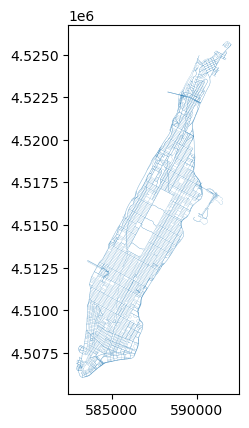

In [ ]:
edges.plot(linewidth=0.1)

In [32]:
crash_df = pd.read_csv("../crash_data.csv")

/var/folders/bb/g7vlcgfn14ld8_w41331g0dw0000gn/T/ipykernel_29888/1649083156.py:1: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  crash_df = pd.read_csv("../crash_data.csv")


In [115]:
crash_df_clean = crash_df[(~crash_df['LATITUDE'].isna()) & (~crash_df['LONGITUDE'].isna()) &
                          (crash_df['LONGITUDE'] > -100) & (crash_df['LONGITUDE'] < -60)]

In [116]:
crash_points = list(zip(crash_df_clean['LATITUDE'], crash_df_clean['LONGITUDE']))

# Project the crash points tograph edges
df_points = pd.DataFrame(crash_points, columns=['y', 'x'])
gdf_points = gpd.GeoDataFrame(df_points, geometry=gpd.points_from_xy(df_points['x'], df_points['y']), crs="EPSG:4326")
gdf_points_proj = gdf_points.to_crs(G_proj.graph['crs'])

In [117]:
nyc_boundary = gpd.read_file("geo/nyc_boroughs.json")
manhattan_bound = nyc_boundary[nyc_boundary['BoroName'] == "Manhattan"].union_all()

In [118]:
manhattan_gdf = gpd.GeoDataFrame(geometry=[manhattan_bound], crs="EPSG:4326").to_crs(G_proj.graph['crs'])

points_within_boundary = gpd.sjoin(
    left_df=gdf_points_proj,
    right_df=manhattan_gdf,
    how='inner',
    predicate='within'
)

In [125]:
points_within_boundary['x'] = points_within_boundary.geometry.x
points_within_boundary['y'] = points_within_boundary.geometry.y

In [126]:
# Convert to list for use in the nearest_edges function
projected_coords = list(zip(points_within_boundary['y'], points_within_boundary['x']))

# map to the neearest edges
nearest_edges = ox.nearest_edges(
    G_proj, 
    X=[x for y, x in projected_coords], # X coordinate list
    Y=[y for y, x in projected_coords]  # Y coordinate list
)

In [127]:
# count the number of times each edge appears
edge_counts = pd.Series(nearest_edges).value_counts()

# Convert the Series to dict for choropleth mapping
edge_counts_dict = edge_counts.to_dict()

In [ ]:
ox.add_edge_speeds(G_proj)

# assign collision counts for each edge of the map
for u, v, k, data in G_proj.edges(keys=True, data=True):
    # Get the count from the dictionary, defaulting to 0 if the edge had no crashes
    data['collision_count'] = edge_counts_dict.get((u, v, k), 0)

In [147]:
cmap_name = 'viridis'

edge_colors = ox.plot.get_edge_colors_by_attr(
    G_proj, 
    attr='collision_count', 
    cmap=cmap_name
)

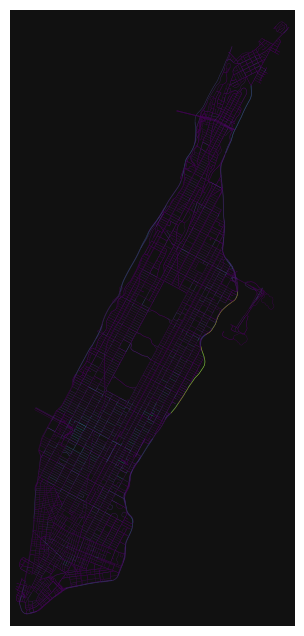

In [148]:
fig, ax = ox.plot_graph(
    G_proj,
    node_size=0,
    edge_color=edge_colors,
    edge_linewidth=0.3,
    edge_alpha=0.8,
    filepath='maps/manhattan_collision_frequency.png',
    save=True,
    show=True, 
    close=True
)

## Agglomerative Clustering to Identify Carpooling (Not Finished)
Simply clustering all of the points at once doesn't work, since that demands an actually absurd amount of memory. Instead, we're going to cluster all of the points in a given time slice, save representative points (centroids) to a new array, and then cluster among the time independent clusters to get those origin destination clusters which are stable across time.

In [ ]:
coords = con.query(
    "SELECT " \
    "   pickup_longitude, pickup_latitude, dropoff_longitude, dropoff_latitude " \
    "FROM " \
    "   taxi_data " \
    "WHERE " \
    "   pickup_longitude IS NOT NULL AND dropoff_longitude IS NOT NULL \
        AND pickup_datetime").df()

In [14]:
from sklearn.cluster import AgglomerativeClustering

model = AgglomerativeClustering(n_clusters=None, metric="euclidean", linkage="complete", distance_threshold=0.5)
cluster_labels = model.fit_predict(coords)

MemoryError: Unable to allocate 17.1 PiB for an array with shape (2408632474551940,) and data type float64

# Deprecated

In [ ]:
from sodapy import Socrata
from dotenv import load_dotenv

In [349]:

load_dotenv()

soda_token = os.getenv("SODA_TOKEN")

client = Socrata("data.cityofnewyork.us", app_token=soda_token)
client.timeout = 120

In [ ]:
results = client.get("uacg-pexx", limit=500000)

results_df = pd.DataFrame.from_records(results)

In [ ]:
results_df = results_df[(results_df['pickup_longitude'] != 0) & (results_df['pickup_latitude'] != 0)]

In [ ]:
results_df.head()

,vendorid,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,pickup_longitude,pickup_latitude,ratecodeid,store_and_fwd_flag,dropoff_longitude,dropoff_latitude,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount
0,2,2016-02-19T19:26:14.000,2016-02-19T19:49:33.000,1,9.36,-73.98419189453125,40.767009735107422,1,N,-73.926651000976562,40.868301391601563,1,28,1,0.5,2.5,0,0.3,32.3
1,1,2016-02-05T18:00:30.000,2016-02-05T18:05:47.000,2,0.8,-73.964889526367187,40.769828796386719,1,N,-73.954902648925781,40.769577026367188,1,5.5,1,0.5,1.5,0,0.3,8.8
2,2,2016-02-21T01:16:58.000,2016-02-21T01:25:32.000,1,2.12,-73.921470642089844,40.755966186523438,1,N,-73.886528015136719,40.755386352539063,1,9,0.5,0.5,0,0,0.3,10.3
3,2,2016-02-27T13:50:17.000,2016-02-27T13:56:02.000,1,0.5,-73.991737365722656,40.729568481445313,1,N,-73.9874267578125,40.733741760253906,1,5.5,0,0.5,1.26,0,0.3,7.56
4,2,2016-02-05T21:01:45.000,2016-02-05T21:27:48.000,1,4.78,-73.951576232910156,40.778469085693359,1,N,-73.998527526855469,40.729530334472656,1,19.5,0.5,0.5,4.16,0,0.3,24.96


# Visualizations
KDE over hour, day, and month of pickups across Manhattan

In [ ]:
results_df['tpep_pickup_datetime'] = pd.to_datetime(results_df['tpep_pickup_datetime'])
results_df['tpep_dropoff_datetime'] = pd.to_datetime(results_df['tpep_dropoff_datetime'])

results_df['pickup_hour'] = results_df['tpep_pickup_datetime'].dt.hour
results_df['pickup_day'] = results_df['tpep_pickup_datetime'].dt.day_of_week
results_df['pickup_month'] = results_df['tpep_pickup_datetime'].dt.month
results_df['date'] = results_df['tpep_pickup_datetime'].dt.date

In [ ]:
fig = px.density_map(
    results_df,
    lat='pickup_latitude',
    lon='pickup_longitude',
    animation_frame='pickup_hour',
    category_orders={'pickup_hour': sorted(results_df['pickup_hour'].unique())},
    radius=2,
    z=None,
    center={'lat': 40.73, 'lon': -74.0},
    zoom=10.5,
    map_style='carto-positron',
    title='Density of Pickup Locations By Hour',
    height=800
)

fig.show()

In [ ]:
fig = px.density_map(
    results_df,
    lat='pickup_latitude',
    lon='pickup_longitude',
    animation_frame='pickup_day',
    category_orders={'pickup_day': sorted(results_df['pickup_day'].unique())},
    radius=2,
    z=None,
    center={'lat': 40.73, 'lon': -74.0},
    zoom=10.5,
    map_style='carto-positron',
    title='Density of Pickup Locations By Day',
    height=800
)

fig.show()

In [ ]:
fig = px.density_map(
    results_df,
    lat='pickup_latitude',
    lon='pickup_longitude',
    animation_frame='pickup_month',
    category_orders={'pickup_month': sorted(results_df['pickup_month'].unique())},
    radius=2,
    z=None,
    center={'lat': 40.73, 'lon': -74.0},
    zoom=10.5,
    map_style='carto-positron',
    title='Density of Pickup Locations By Month',
    height=800
)

fig.show()

## Test Aggregation Code

In [ ]:
hr_average_pu = {}
hr_average_do = {}
hr_average_pu_do = {}

day_average_pu = {}
day_average_do = {}
day_average_pu_do = {}

month_average_pu = {}
month_average_do = {}
month_average_pu_do = {}

In [ ]:
results_df['pickup_latitude'] = results_df['pickup_latitude'].astype(float)
results_df['pickup_longitude'] = results_df['pickup_longitude'].astype(float)
results_df['dropoff_latitude'] = results_df['dropoff_latitude'].astype(float)
results_df['dropoff_longitude'] = results_df['dropoff_longitude'].astype(float)

In [ ]:
def merge_pu_do_dicts(time_average_d: dict, slice_times: pd.Series) -> dict:
    for period in slice_times.index.get_level_values(0).unique():
        time_average_d[period] = time_average_d.get(period, pd.Series(dtype=float)).add(slice_times[period], fill_value=0)

    return time_average_d

In [ ]:
results_df['pu_cell_id'] = results_df.apply(lambda row: h3.latlng_to_cell(
    lat=row['pickup_latitude'],
    lng=row['pickup_longitude'],
    res=10
), axis=1)

results_df['do_cell_id'] = results_df.apply(lambda row: h3.latlng_to_cell(
    lat=row['dropoff_latitude'],
    lng=row['dropoff_longitude'],
    res=10
), axis=1)
results_df['pu_do_ids'] = results_df['pu_cell_id'].str.cat(results_df['do_cell_id'], sep="_")

In [ ]:
pu_cell_id_by_hr = results_df.groupby('pickup_hour')['pu_cell_id'].value_counts()
pu_cell_id_by_day = results_df.groupby('pickup_day')['pu_cell_id'].value_counts()
pu_cell_id_by_month = results_df.groupby('pickup_month')['pu_cell_id'].value_counts()

do_cell_id_by_hr = results_df.groupby('pickup_hour')['do_cell_id'].value_counts()
do_cell_id_by_day = results_df.groupby('pickup_day')['do_cell_id'].value_counts()
do_cell_id_by_month = results_df.groupby('pickup_month')['do_cell_id'].value_counts()

pu_do_id_by_hr = results_df.groupby('pickup_hour')['pu_do_ids'].value_counts()
pu_do_id_by_day = results_df.groupby('pickup_day')['pu_do_ids'].value_counts()
pu_do_id_by_month = results_df.groupby('pickup_month')['pu_do_ids'].value_counts()

In [ ]:
hr_average_pu = merge_pu_do_dicts(hr_average_pu, pu_cell_id_by_hr)
day_average_pu = merge_pu_do_dicts(day_average_pu, pu_cell_id_by_day)
month_average_pu = merge_pu_do_dicts(month_average_pu, pu_cell_id_by_month)

hr_average_do = merge_pu_do_dicts(hr_average_do, do_cell_id_by_hr)
day_average_do = merge_pu_do_dicts(day_average_do, do_cell_id_by_day)
month_average_do = merge_pu_do_dicts(month_average_do, do_cell_id_by_month)

hr_average_pu_do = merge_pu_do_dicts(hr_average_pu_do, pu_do_id_by_hr)
day_average_pu_do = merge_pu_do_dicts(day_average_pu_do, pu_do_id_by_day)
month_average_pu_do = merge_pu_do_dicts(month_average_pu_do, pu_do_id_by_month)

summing pu_cell_id
8a2a100122b7fff      1.0
8a2a10013177fff      1.0
8a2a100136d7fff      1.0
8a2a10013adffff      1.0
8a2a10015c77fff      1.0
                   ...  
8a2a10775917fff      1.0
8a2a10775a57fff      1.0
8a2a10775ac7fff      1.0
8a2a10776c2ffff      1.0
8a754e64992ffff    275.0
Length: 2505, dtype: float64 and pickup_hour  pu_cell_id     
0            8a754e64992ffff    275
             8a2a103b1c97fff    144
             8a2a10721b1ffff     92
             8a2a1072caa7fff     83
             8a2a100d2c17fff     80
                               ... 
             8a2a1077590ffff      1
             8a2a10775917fff      1
             8a2a10775a57fff      1
             8a2a10775ac7fff      1
             8a2a10776c2ffff      1
Name: count, Length: 2505, dtype: int64
summing pu_cell_id
8a2a10012487fff      1.0
8a2a1001c49ffff      1.0
8a2a1001e807fff      1.0
8a2a100367b7fff      1.0
8a2a1005260ffff      1.0
                   ...  
8a2a10d592dffff      1.0
8a2a12b6cacfff